In [4]:
import os

from decimal import Decimal
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.applications import vgg19

# import IPython.display as display
from IPython.display import display, Image, clear_output
import PIL.Image

In [7]:
content_urls = dict(
    labrador = '',
    gato1 = 'https://upload.wikimedia.org/wikipedia/commons/e/e5/Blue-eyed_domestic_cat_%28Felis_silvestris_catus%29.jpg',
    gato2 = 'https://upload.wikimedia.org/wikipedia/commons/0/0e/Felis_silvestris_silvestris.jpg',
    messi = 'https://www.aljazeera.com/wp-content/uploads/2022/12/SSS10784_1.jpg'
)

style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg',
  arg='https://www.shutterstock.com/shutterstock/photos/2359179649/display_1500/stock-vector-argentina-flag-pattern-design-vector-illustration-2359179649.jpg'
)

354200/354200 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


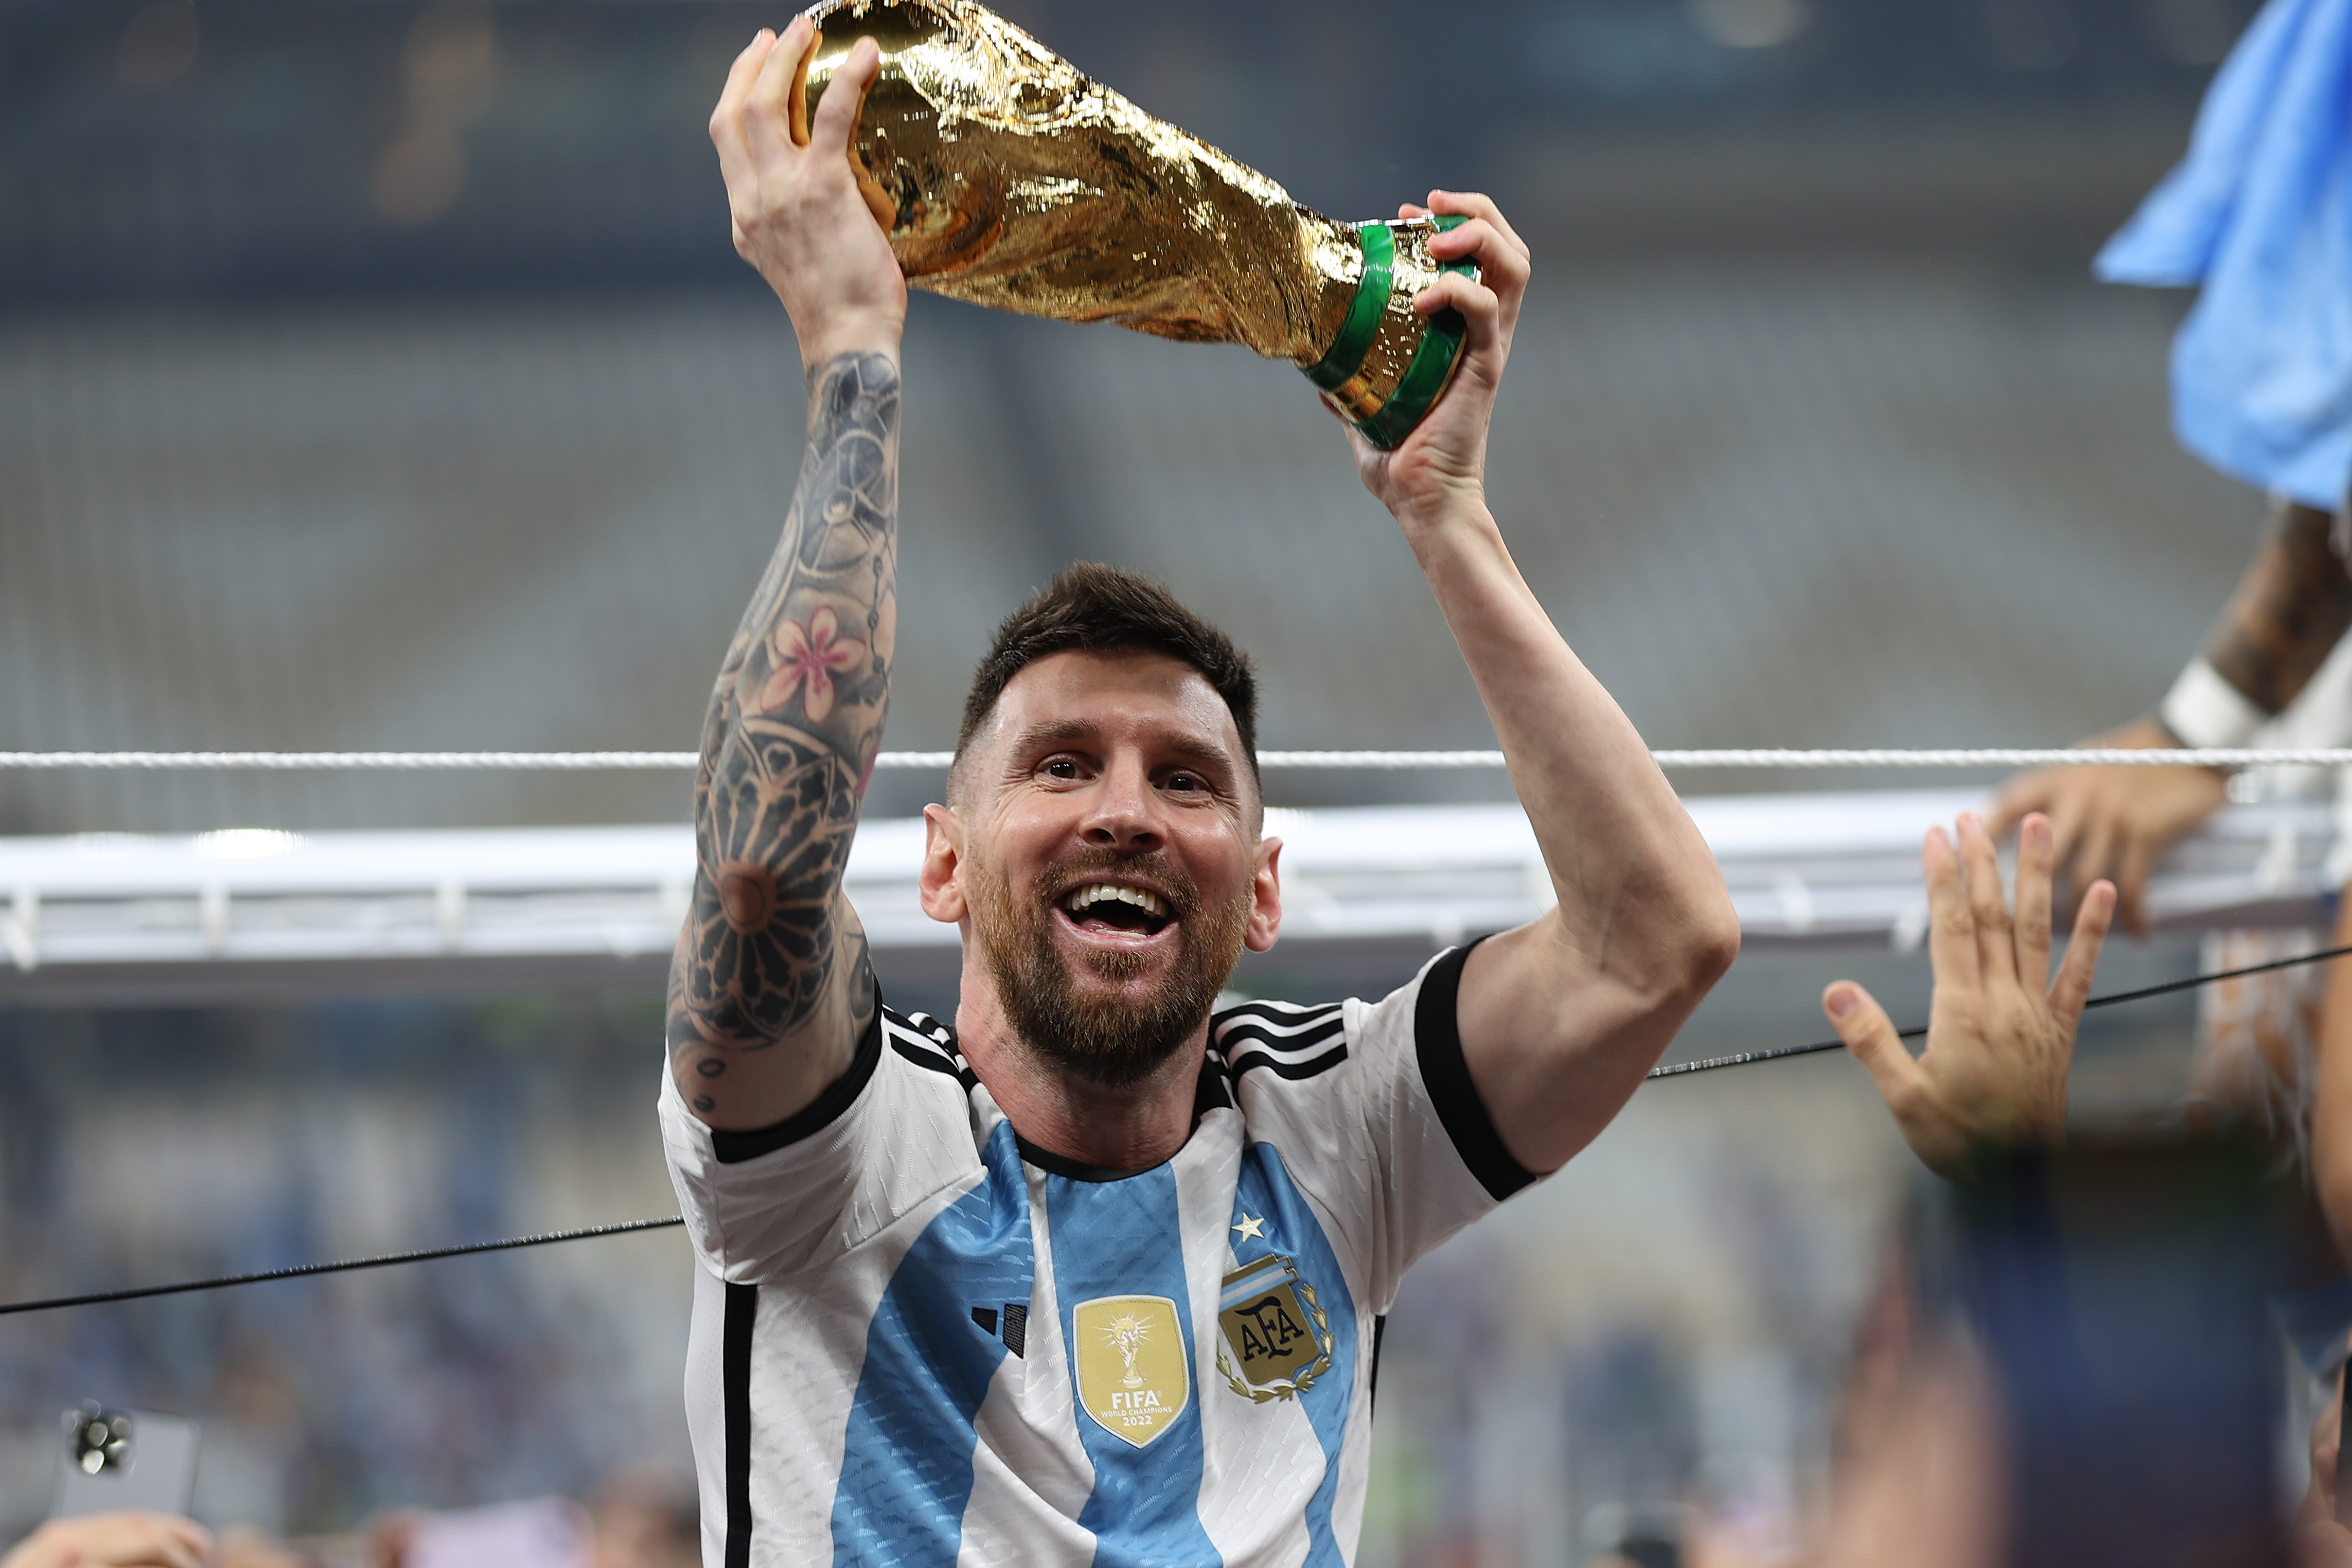

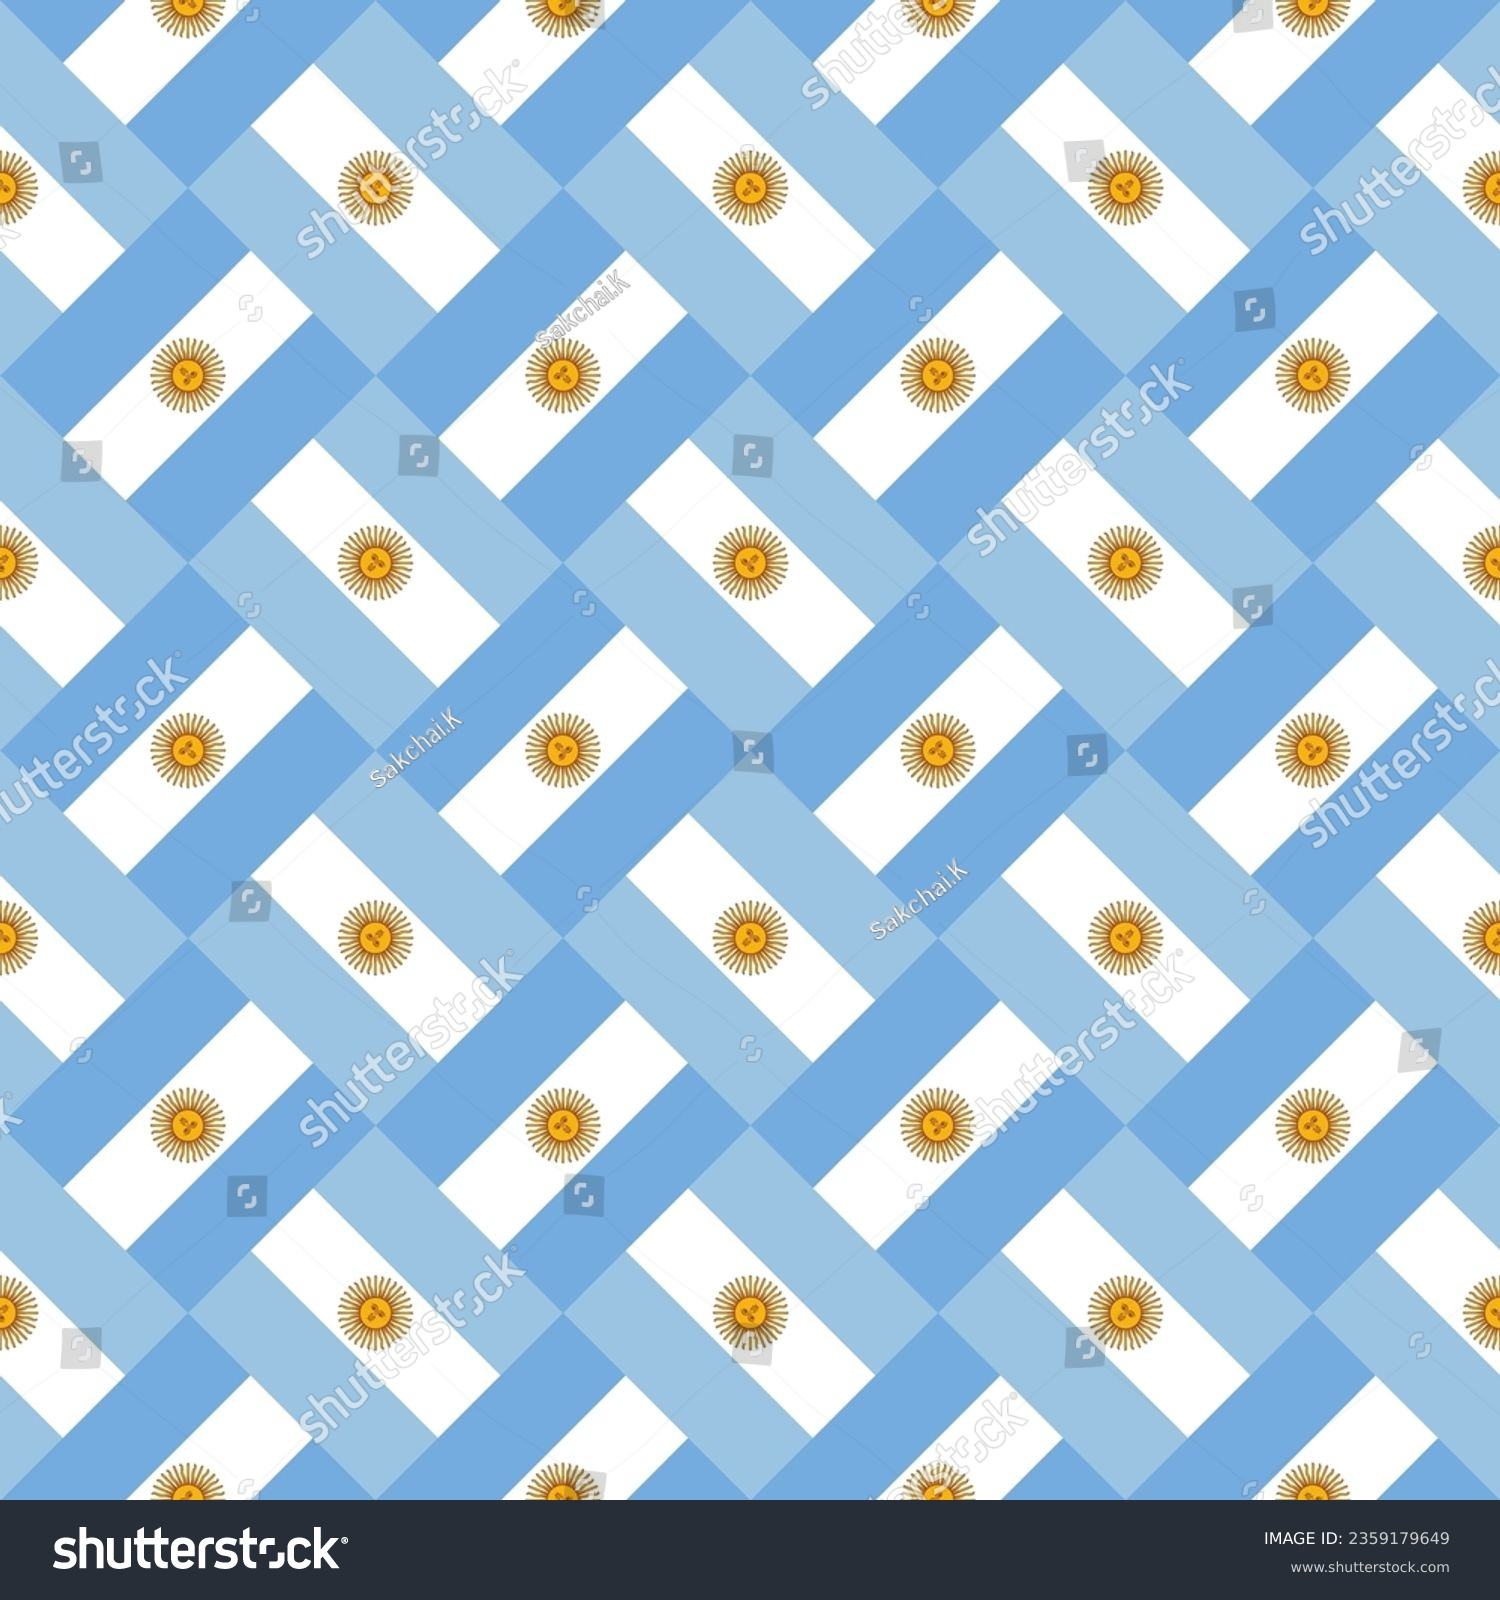

In [8]:
result_prefix = "paris_generated"

# base_image_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_reference_image_path = os.path.join(os.getcwd(), 'styles', 'starry_night.jpeg')
content_url = content_urls['messi']
base_image_path = tf.keras.utils.get_file(os.path.basename(content_url)[-128:], content_url)

style_url = style_urls['arg']
style_reference_image_path = tf.keras.utils.get_file(os.path.basename(style_url)[-128:], style_url)

# Weights of the different loss components
total_variation_weight = 10
style_weight = 0
content_weight = 1000

# Dimensions of the generated picture.
width, height = keras.utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

"""
## Let's take a look at our base (content) image and our style reference image
"""

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [115]:
"""
## Image preprocessing / deprocessing utilities
"""

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [116]:
"""
## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent
"""

# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))
    # return tf.image.total_variation(x)

In [117]:
"""
Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).
"""

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

"""
Finally, here's the code that computes the style transfer loss.
"""

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

In [118]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


"""
## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.
"""


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Train step: 4000, loss: 23037605888.0


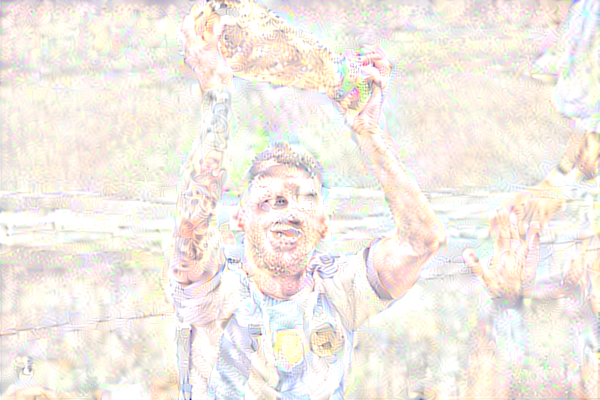

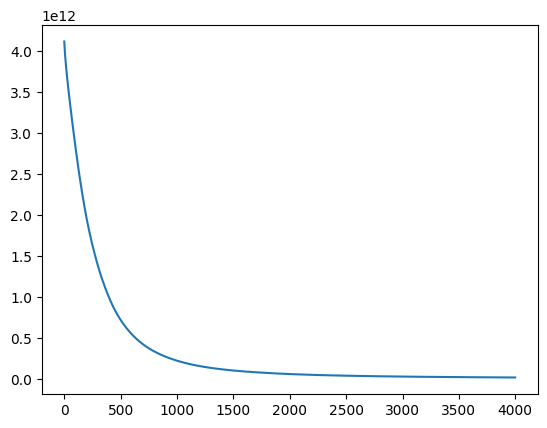

In [120]:
"""
## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.
"""

# optimizer = keras.optimizers.SGD(
#     keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
#     )
# )

optimizer = keras.optimizers.Adam(learning_rate=.2, beta_1=0.99, epsilon=1e-1)
# optimizer = keras.optimizers.Adam(learning_rate= keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=10.0, decay_steps=100, decay_rate=0.01),
#                                   beta_1=0.99,
#                                   epsilon=1e-1)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# combination_image = tf.Variable(preprocess_image(base_image_path))
combination_image = tf.Variable(
    tf.random.uniform(shape=[1, img_nrows, img_ncols, 3], minval=0, maxval=256)
)
step = 0
epochs = 200
steps_per_epoch = 20
loss_history = []

for i in range(1, epochs + 1):
    print("Start of epoch %d" % i)
    for j in range(steps_per_epoch):
        step += 1
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_reference_image
        )
        optimizer.apply_gradients([(grads, combination_image)])
        loss_history.append(loss)
        print(".", end='', flush=True)
    img = deprocess_image(combination_image.numpy())
    clear_output(wait=True)
    print(f"Train step: {step}, loss: {loss}")
    display(PIL.Image.fromarray(img))
    plt.plot(loss_history)
    plt.show()
    # print("Iteration %d: loss=%.2f" % (i, loss))
    # fname = result_prefix + "_at_iteration_%d.png" % i
    # keras.utils.save_img(fname, img)


# display(Image(result_prefix + "_at_iteration_4000.png"))